In [1]:
import time
import sqlite3
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report  #conf matrix
import seaborn as sns #conf matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from time import time
import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score

#from utils import mean_absolute_percentage_error

# LOAD DATA

In [2]:
cn = sqlite3.connect('../laliga.sqlite')
df = pd.read_sql_query("SELECT * FROM Matches", cn)
df_aux = df
df_aux

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2
...,...,...,...,...,...,...,...,...
49015,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None
49016,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None
49017,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None
49018,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None


## NEW FEATURES

In [3]:
def parse_score(score):
    w = ''
    if score:
        score = score.split(':')
        if score[0] > score[1]:
            w = 1
        elif score[0] < score[1]:
            w = 2
        elif score[0] == score[1]:
            w = 0
    else:
        w = 'Unknown'
    return w

# Match results
scores = df_aux['score'].values
scores = [x.split(':') if x else [-1, -1] for x in scores]
df_aux['Result'] = df_aux['score'].apply(parse_score)

In [4]:
#Home goals and away goals
home_goals = []
away_goals = []
for scored_goals in scores:
    home_goals.append(scored_goals[0])
    away_goals.append(scored_goals[1])
df_aux['home_goals'] = pd.to_numeric(home_goals)
df_aux['away_goals'] = pd.to_numeric(away_goals)
# Goal difference
df_aux['goal_difference'] = abs(df_aux['home_goals'] - df_aux['away_goals'])
df_aux['total_goals'] = df_aux['home_goals'] + df_aux['away_goals']

In [5]:
#Assigning values to each time in order of aparison
teams = df_aux['home_team'].drop_duplicates().values
df_aux['home_id'] = 0
df_aux['away_id'] = 0
df_aux
for i in range(len(teams)):
    df_aux.loc[df_aux['home_team'] == teams[i], ['home_id']] = i
    df_aux.loc[df_aux['away_team'] == teams[i], ['away_id']] = i

#droping unknown
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['Result'])
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['date'])
df_aux.reset_index(drop=True, inplace=True) #reset index after droping the unknown

In [6]:
# new columns
df_aux['FHG_dm']= np.nan #Feature home goals (last direct matches)
df_aux['FAG_dm']= np.nan #Feature away goals (last direct matches)
df_aux['FTG_dm']= np.nan #Feature total goals (last direct matches)
df_aux['FDG_dm']= np.nan #Feature difference goals (last direct matches)
df_aux['VHT_dm']= np.nan #victories home team ( last direct matches)
df_aux['VAT_dm']= np.nan #victories away team ( last direct matches)

df_aux['FHG']= np.nan #Feature home goals (last matches)
df_aux['FAG']= np.nan #Feature away goals (last matches)
df_aux['VHT']= np.nan #victories home team ( last matches)
df_aux['VAT']= np.nan #victories away team ( last matches)

In [7]:
def fix_date(date): 
    if date.year > 2021:
        year = date.year - 100
    else:
        year = date.year
    return datetime.date(int(year),date.month,date.day)
#change date format
df_aux['date'] = pd.to_datetime(df_aux['date']).dt.date
#fix date
df_aux['date'] = df_aux['date'].apply(fix_date)
print(df_aux)

          season  division  matchday        date      time        home_team  \
0      1928-1929         1         1  1929-02-10      None      Arenas Club   
1      1928-1929         1         1  1929-02-10      None         Espanyol   
2      1928-1929         1         1  1929-02-10      None      Real Madrid   
3      1928-1929         1         1  1929-02-10      None         Donostia   
4      1928-1929         1         1  1929-02-12      None           Racing   
...          ...       ...       ...         ...       ...              ...   
48235  2021-2022         2         3  2021-08-28  10:00 PM     Ponferradina   
48236  2021-2022         2         3  2021-08-29   5:00 PM    SD Amorebieta   
48237  2021-2022         2         3  2021-08-29   7:30 PM          CD Lugo   
48238  2021-2022         2         3  2021-08-29   7:30 PM  Real Sociedad B   
48239  2021-2022         2         3  2021-08-29  10:00 PM        Burgos CF   

             away_team score Result  home_goals  ..

In [8]:
def last_dir_matches(df,row,num):
    h_t = row['home_id']
    a_t = row['away_id']
    date = row['date']
    #get direct matches
    matches = df[((df['home_id']== h_t) & (df['away_id'] == a_t )) | ((df['home_id']== a_t) & (df['away_id'] == h_t))]
    #get last matches of direct matches
    last_matches = matches[matches['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    if (len(last_matches) == num):
    #column of total goals, away goals, home goals, diference goals
        total_goals = last_matches['total_goals'].sum()
        diff_goals = last_matches['goal_difference'].sum()
        
        team_home_hg = last_matches['home_goals'][last_matches['home_id'] == h_t].sum() 
        team_home_ag = last_matches['away_goals'][last_matches['away_id'] == h_t].sum()
        team_away_hg = last_matches['home_goals'][last_matches['home_id'] == a_t].sum()
        team_away_ag = last_matches['away_goals'][last_matches['away_id'] == a_t].sum()
        
        team_home_vh= (last_matches['Result'] == 1)[last_matches['home_id'] == h_t].sum(axis=0)
        team_home_va= (last_matches['Result'] == 2)[last_matches['away_id'] == h_t].sum(axis=0)
        team_away_vh= (last_matches['Result'] == 2)[last_matches['away_id'] == a_t].sum(axis=0)
        team_away_va= (last_matches['Result'] == 1)[last_matches['home_id'] == a_t].sum(axis=0)
        
        row['FTG_dm'] = int(total_goals)
        row['FDG_dm'] = int(diff_goals)
        row['FHG_dm'] = int(team_home_hg + team_home_ag)
        row['FAG_dm'] = int(team_away_hg + team_away_ag)
        row['VHT_dm'] = int(team_home_vh + team_home_va)
        row['VAT_dm'] = int(team_away_vh + team_away_va)
    return row
    

In [9]:
def last_matches(df,row,num):
    h_t = row['home_id']
    a_t = row['away_id']
    date = row['date']
    #get direct matches
    matches_h = df[(df['home_id']== h_t) | (df['away_id'] == h_t )]
    matches_a = df[((df['home_id']== a_t) | (df['away_id'] == a_t ))]
    #get last matches of direct matches
    last_matches_h = matches_h[matches_h['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    last_matches_a = matches_a[matches_a['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    if ((len(last_matches_h) == num) and (len(last_matches_a) == num)):
        team_home_hg = last_matches_h['home_goals'][last_matches_h['home_id'] == h_t].sum() 
        team_home_ag = last_matches_h['away_goals'][last_matches_h['away_id'] == h_t].sum()
        team_away_hg = last_matches_a['home_goals'][last_matches_a['home_id'] == a_t].sum()
        team_away_ag = last_matches_a['away_goals'][last_matches_a['away_id'] == a_t].sum()
        
        team_home_vh= (last_matches_h['Result'] == 1)[last_matches_h['home_id'] == h_t].sum(axis=0)
        team_home_va= (last_matches_h['Result'] == 2)[last_matches_h['away_id'] == h_t].sum(axis=0)
        team_away_vh= (last_matches_a['Result'] == 2)[last_matches_a['away_id'] == a_t].sum(axis=0)
        team_away_va= (last_matches_a['Result'] == 1)[last_matches_a['home_id'] == a_t].sum(axis=0)
        
        row['FHG'] = int(team_home_hg + team_home_ag)
        row['FAG'] = int(team_away_hg + team_away_ag)
        row['VHT'] = int(team_home_vh + team_home_va)
        row['VAT'] = int(team_away_vh + team_away_va)
    return row

In [10]:
num=5
#df_aux= df_aux.iloc[0:20000,:]
df_aux= df_aux.apply(lambda row: last_matches(df_aux, row,num),axis=1)


In [11]:
num=7
#df_aux= df_aux.iloc[0:20000,:]
df_aux= df_aux.apply(lambda row: last_dir_matches(df_aux, row,num),axis=1)

In [12]:
#droping unknown
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['FHG_dm'])
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['FHG'])
df_aux.reset_index(drop=True, inplace=True) #reset index after droping the unknown
df_aux['FHG_dm']=df_aux['FHG_dm'].astype('int')
df_aux['FAG_dm']=df_aux['FAG_dm'].astype('int')
df_aux['FTG_dm']=df_aux['FTG_dm'].astype('int')
df_aux['FDG_dm']=df_aux['FDG_dm'].astype('int')
df_aux['VHT_dm']=df_aux['VHT_dm'].astype('int')
df_aux['VAT_dm']=df_aux['VAT_dm'].astype('int')
df_aux['FHG']=df_aux['FHG'].astype('int')
df_aux['FAG']=df_aux['FAG'].astype('int')
df_aux['VAT']=df_aux['VAT'].astype('int')
df_aux['VHT']=df_aux['VHT'].astype('int')
print(df_aux)

          season  division  matchday        date      time       home_team  \
0      1931-1932         1        10  1932-02-07      None        Donostia   
1      1931-1932         1        10  1932-02-07      None       Barcelona   
2      1931-1932         1        10  1932-02-07      None        Athletic   
3      1931-1932         1        11  1932-02-14      None     Arenas Club   
4      1931-1932         1        11  1932-02-14      None     Real Madrid   
...          ...       ...       ...         ...       ...             ...   
28595  2021-2022         2         3  2021-08-27   8:00 PM   UD Las Palmas   
28596  2021-2022         2         3  2021-08-28   5:00 PM  Sporting Gijón   
28597  2021-2022         2         3  2021-08-28   7:30 PM     Real Oviedo   
28598  2021-2022         2         3  2021-08-28  10:00 PM    Ponferradina   
28599  2021-2022         2         3  2021-08-29   7:30 PM         CD Lugo   

             away_team score  Result  home_goals  ...  FHG_dm  

## Feature Selection 


## Pearson correlation

We calculate the absolute value of the Pearson's correlation between the target and features. We keep the top n features based on this criterion.

In [78]:
y= df_aux['Result'].astype('int')
features=['FHG_dm','FAG_dm','FTG_dm','FDG_dm','VHT_dm','VAT_dm','FHG','FAG','VHT','VAT']
X= df_aux[features].astype('int')
num_features= 4

In [79]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_features)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

4 selected features
['FHG_dm', 'VHT_dm', 'VAT_dm', 'VHT']


In [80]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(multi_class='ovr', max_iter=500,class_weight="balanced"), n_features_to_select=num_features, step=20, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 10 features.
4 selected features
['FHG_dm', 'FAG_dm', 'FHG', 'FAG']


In [56]:
def Pearson_select(X, y,num_features):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation for each feature
    for i in feature_name:
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # feature name
    feature_selection = X.iloc[:,np.argsort(np.abs(cor_list))[-num_features:]].columns.tolist()
    # feature selection
    cor_support = [True if i in feature_selection else False for i in feature_name]
    return cor_list, feature_selection

cor_list, feature_selection = Pearson_select(X, y,num_features)
print('features selected:',feature_selection)
print('correlations of features:',cor_list)

features selected: ['VAT', 'VHT_dm', 'VAT_dm', 'FAG', 'FAG_dm']
correlations of features: [-0.020080234363418176, 0.07466513057012691, 0.040292232963687405, 0.03631943129203532, -0.04602250016483261, 0.05378511451031742, 0.0038806873209110307, 0.06500003371570408, -0.021424027938102143, 0.04304510379590492]


# SPLIT DATA TRAIN AND TEST

In [81]:
features = ['FHG_dm', 'FAG_dm', 'FDG_dm', 'FHG', 'FAG']
features = ['FHG_dm', 'FAG_dm', 'FHG', 'FAG']
target = 'Result'
X = df_aux[features]
y = df_aux[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (22880, 4)
X_test shape: (5720, 4)
y_train shape: (22880,)
y_test shape: (5720,)


In [82]:
### Sin esto da problemas model.fit 

In [83]:
X_train = X_train.astype('int')
X_test = X_test.astype('int')
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# TRAIN AND TEST

In [84]:
def train_test(model, X_train, y_train, X_test, y_test):
    from sklearn import metrics
    #TRAIN
    start = time()
    model.fit(X_train, y_train)
    end = time()
    t = end-start
    print("The model has been trained in {:2f} seconds".format(t))
    
    #PREDICTIONS
    start = time()
    y_pred = model.predict(X_test)
    end = time()
    t = end-start
    print("The predictions have been made in {:2f} seconds".format(t))
    
    labels = ['Tie', 'Home win', 'Away Win']
    #metrics
    print(metrics.classification_report(y_test, y_pred, target_names=labels))
    print("F1 Score: ", metrics.f1_score(y_test, y_pred, average='macro'))
    print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    print("Recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
    print("Precision: ", metrics.precision_score(y_test, y_pred, average='macro'))
    
    return y_pred
    

# MODELS

### Linear model --> it doesn't work well

In [85]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier(seed=22)
classifier.fit(X_train, y_train)

[18:06:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=22, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=22, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [86]:
Y_pred = classifier.predict(X_test)
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.22      0.02      0.04      1477
           1       0.53      0.94      0.68      2982
           2       0.41      0.10      0.16      1261

    accuracy                           0.52      5720
   macro avg       0.39      0.35      0.29      5720
weighted avg       0.42      0.52      0.40      5720



### Logistic Regression

EN LOGISTIC REGRESSION PUEDES USAR CLASS_WEIGHT= "BALANCED"-> para unbalanced classes

In [87]:
lr = LogisticRegression(multi_class='ovr', max_iter=300,class_weight="balanced")

In [88]:
print("Logistic Regression:")
y_pred_lr = train_test(lr, X_train, y_train, X_test, y_test)

Logistic Regression:
The model has been trained in 0.098486 seconds
The predictions have been made in 0.000000 seconds
              precision    recall  f1-score   support

         Tie       0.30      0.26      0.28      1477
    Home win       0.62      0.52      0.57      2982
    Away Win       0.31      0.47      0.37      1261

    accuracy                           0.44      5720
   macro avg       0.41      0.42      0.41      5720
weighted avg       0.47      0.44      0.45      5720

F1 Score:  0.4067674527153951
Accuracy:  0.4433566433566434
Recall:  0.4181760701125092
Precision:  0.40973742610673664


###  Random Forest

In [25]:
rf = RandomForestClassifier(class_weight="balanced")

In [26]:
print("Random Forest:")
y_pred_rf = train_test(rf, X_train, y_train, X_test, y_test)

Random Forest:
The model has been trained in 1.511409 seconds
The predictions have been made in 0.104296 seconds
              precision    recall  f1-score   support

         Tie       0.27      0.32      0.29      1477
    Home win       0.57      0.45      0.50      2982
    Away Win       0.26      0.33      0.29      1261

    accuracy                           0.39      5720
   macro avg       0.37      0.37      0.36      5720
weighted avg       0.42      0.39      0.40      5720

F1 Score:  0.36274707185252364
Accuracy:  0.39125874125874127
Recall:  0.36750927142054873
Precision:  0.36636391779595145


###  Decision tree classifier

In [27]:
dt = DecisionTreeClassifier()

In [28]:
print(" Decision tree classifier:")
y_pred_dt = train_test(dt, X_train, y_train, X_test, y_test)

 Decision tree classifier:
The model has been trained in 0.025108 seconds
The predictions have been made in 0.000000 seconds
              precision    recall  f1-score   support

         Tie       0.25      0.18      0.21      1477
    Home win       0.53      0.73      0.62      2982
    Away Win       0.29      0.13      0.18      1261

    accuracy                           0.46      5720
   macro avg       0.36      0.35      0.33      5720
weighted avg       0.41      0.46      0.41      5720

F1 Score:  0.3334791255176696
Accuracy:  0.4550699300699301
Recall:  0.34567505364638773
Precision:  0.3569936898039612


### Gaussain Naive Bayes

In [29]:
gnb= GaussianNB(var_smoothing=1.1)

In [30]:
print(" Gaussain Naive Bayes:")
y_pred_gnb = train_test(gnb, X_train, y_train, X_test, y_test)

 Gaussain Naive Bayes:
The model has been trained in 0.005462 seconds
The predictions have been made in 0.001000 seconds
              precision    recall  f1-score   support

         Tie       0.00      0.00      0.00      1477
    Home win       0.52      1.00      0.69      2982
    Away Win       0.59      0.02      0.03      1261

    accuracy                           0.52      5720
   macro avg       0.37      0.34      0.24      5720
weighted avg       0.40      0.52      0.36      5720

F1 Score:  0.23887622872394446
Accuracy:  0.5230769230769231
Recall:  0.3375023247246276
Precision:  0.370307532087756


### Multinomial Naive Bayes

In [31]:
mnb= MultinomialNB()

In [32]:
print(" Gaussain Naive Bayes:")
y_pred_mbn = train_test(mnb, X_train, y_train, X_test, y_test)

 Gaussain Naive Bayes:
The model has been trained in 0.006739 seconds
The predictions have been made in 0.001028 seconds
              precision    recall  f1-score   support

         Tie       0.00      0.00      0.00      1477
    Home win       0.55      0.86      0.67      2982
    Away Win       0.34      0.28      0.31      1261

    accuracy                           0.51      5720
   macro avg       0.30      0.38      0.33      5720
weighted avg       0.36      0.51      0.42      5720

F1 Score:  0.32625857044606926
Accuracy:  0.5118881118881119
Recall:  0.38099776737790386
Precision:  0.29692898962061637


###  Support Vector Classification --> takes a long time

In [33]:
# svc_rbf = SVC(random_state=100, kernel='rbf')

In [34]:
#print("Support Vector Classification (Radial Basis Function):")
#train_test(svc_rbf, X_train, y_train, X_test, y_test)

# where does it fail the most

You can change the model plot just changing the name of y_pred to see how the model behaves.

General behavour: Most models predict home_team wins better than away_team wins. Ties are very poorly predicted for all models.

## Confusion_matrix

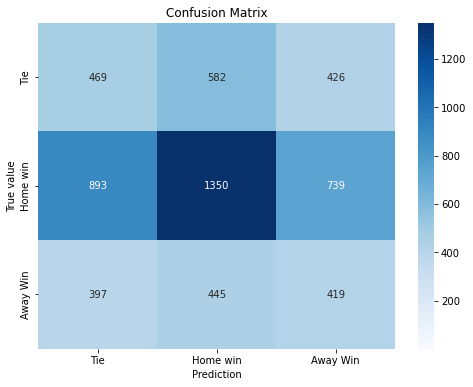

In [35]:
#Print Confusion Matrix
## PONER EN Y_pred el modelo que quieres!!
cm = confusion_matrix(y_test, y_pred_rf)
labels = ['Tie', 'Home win', 'Away Win']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2)
plt.title('Confusion Matrix')
plt.ylabel('True value')
plt.xlabel('Prediction')
plt.show()

## True result, well prediction, bad pred

In [36]:
index= X_test.index
df_pred= df_aux.loc[index]
df_pred['prediction'] = y_pred_rf
columns= ['season','division','matchday','date','home_team','away_team','Result','prediction']
df_pred= df_pred[columns]

In [37]:
result = df_pred['Result'].value_counts()
pred= df_pred[['prediction','Result']]
good_pred= pred[pred['prediction'] == pred['Result']].value_counts()
good_pred.reset_index(drop=True, inplace=True, level='Result')

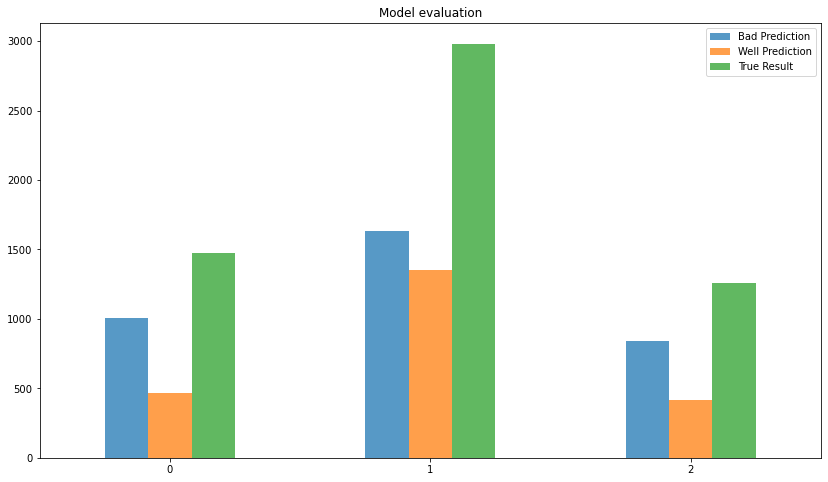

In [38]:
bad_pred= pred[(pred['prediction'] != pred['Result'])].groupby('Result').count()
bad_pred= bad_pred['prediction']
evaluation= pd.concat([bad_pred, good_pred,result], axis=1, keys=['Bad Prediction','Well Prediction','True Result']).plot(kind='bar',
            figsize=(14,8),
            title="Model evaluation",alpha=0.75, rot=0)


## Analysis of failures and successes

Result        0     1    2
prediction                
0           469   893  397
1           582  1350  445
2           426   739  419


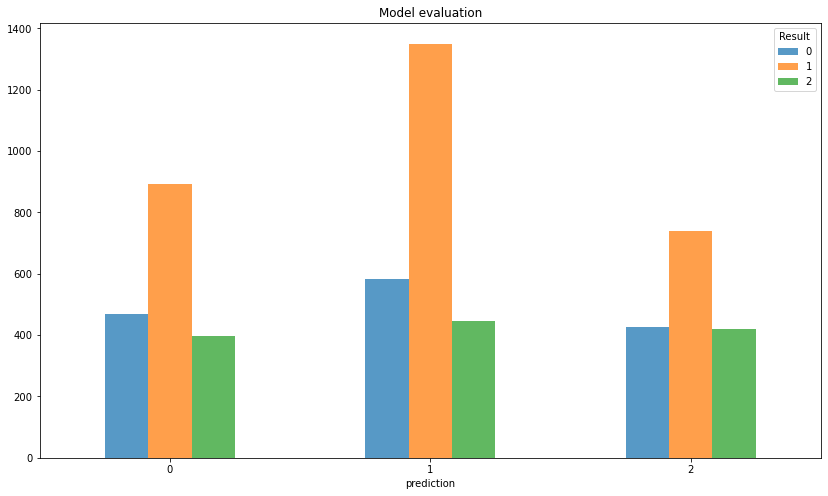

In [39]:
fail_suc= pred[(pred['prediction'] != pred['Result']) | (pred['prediction'] == pred['Result']) ].value_counts()
fail_suc= pd.DataFrame(fail_suc)
fail_suc = fail_suc.unstack()
fail_suc[0].plot(kind='bar',
            figsize=(14,8),
            title="Model evaluation",alpha=0.75, rot=0)

print(fail_suc[0])


# EXPORT MODEL

This only exports the last model run and the TEST

In [40]:
#Replace 0 with X
df_pred[['Result','prediction']] = df_pred[['Result','prediction']].astype(str) 
df_pred[['Result','prediction']]= df_pred[['Result','prediction']].replace('0','X')

shouldExport = input('Do you want to export the model(s) (y / n) ? ')
if shouldExport.strip().lower() == 'y':
    df_pred.to_excel("../models/Predictions.xlsx")